The proposal for this project is to use machine learning to detect patterns in the sensor data so that the stackeholer will be better to exploit the forecasting and act accordingly by maintaining the unterlying system. 

This notebook is keept in such a way as I went trough it. However, weak results are not interfering with final outcomes and predictions.

We are going to use the following python libraries and therefore the upcoming cell is going to install it for us.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pump-sensor-data/sensor.csv


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller


# Data Loading

In [3]:
# np.genfromtxt('sensor.csv', delimiter=',', dtype=None)
df = pd.read_csv('../input/pump-sensor-data/sensor.csv')

# Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

There are some missing values. Some columns will be dropped as seen in the upcoming column. 
Those columns with only a few missing values will be 'backfilled' with the pandas method in the later stage of this notebook.

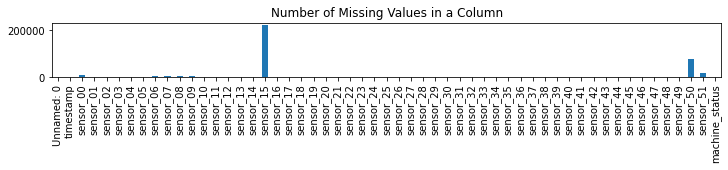

In [5]:
df.isnull().sum().plot(kind='bar', figsize=(12,1));
plt.title('Number of Missing Values in a Column');

In the next step visual inspectation of each sensor record is made. 

In [6]:
# Transforming mashine status from strings to integers 
conditions = [(df['machine_status'] =='NORMAL'), (df['machine_status'] =='BROKEN'), (df['machine_status'] =='RECOVERING')]
choices = [1, 0, 0.5]
df['Operation'] = np.select(conditions, choices, default=0)

We can see group by some sensors in terms of their behavior and the absolute numbers they display. All sensors show stationary behavior, which means that their values are not changing from the initial value in time. Non-stationary behaviour we be that the values are rising / or falling in time.

In the further notebook you will see that stationary/non-stationary behavior with random forest is not so important. However, for completness it is still i to check.

In [7]:
# Commented out, because the run is computionally expensive!

# Since the p-values are printed out. All values below 0.05 are concidered as less significant and mostly likely a stationary behaviour.
# for i, s in enumerate(df.drop(['timestamp', 'machine_status', 'Operation'], axis = 1).dropna().T.to_numpy()):
#    result = adfuller(s)
#    print(f'Sensor {i}:', result[1])

Another visualisation for the dataset. The red dotted lines are showing the time point of machine failure.

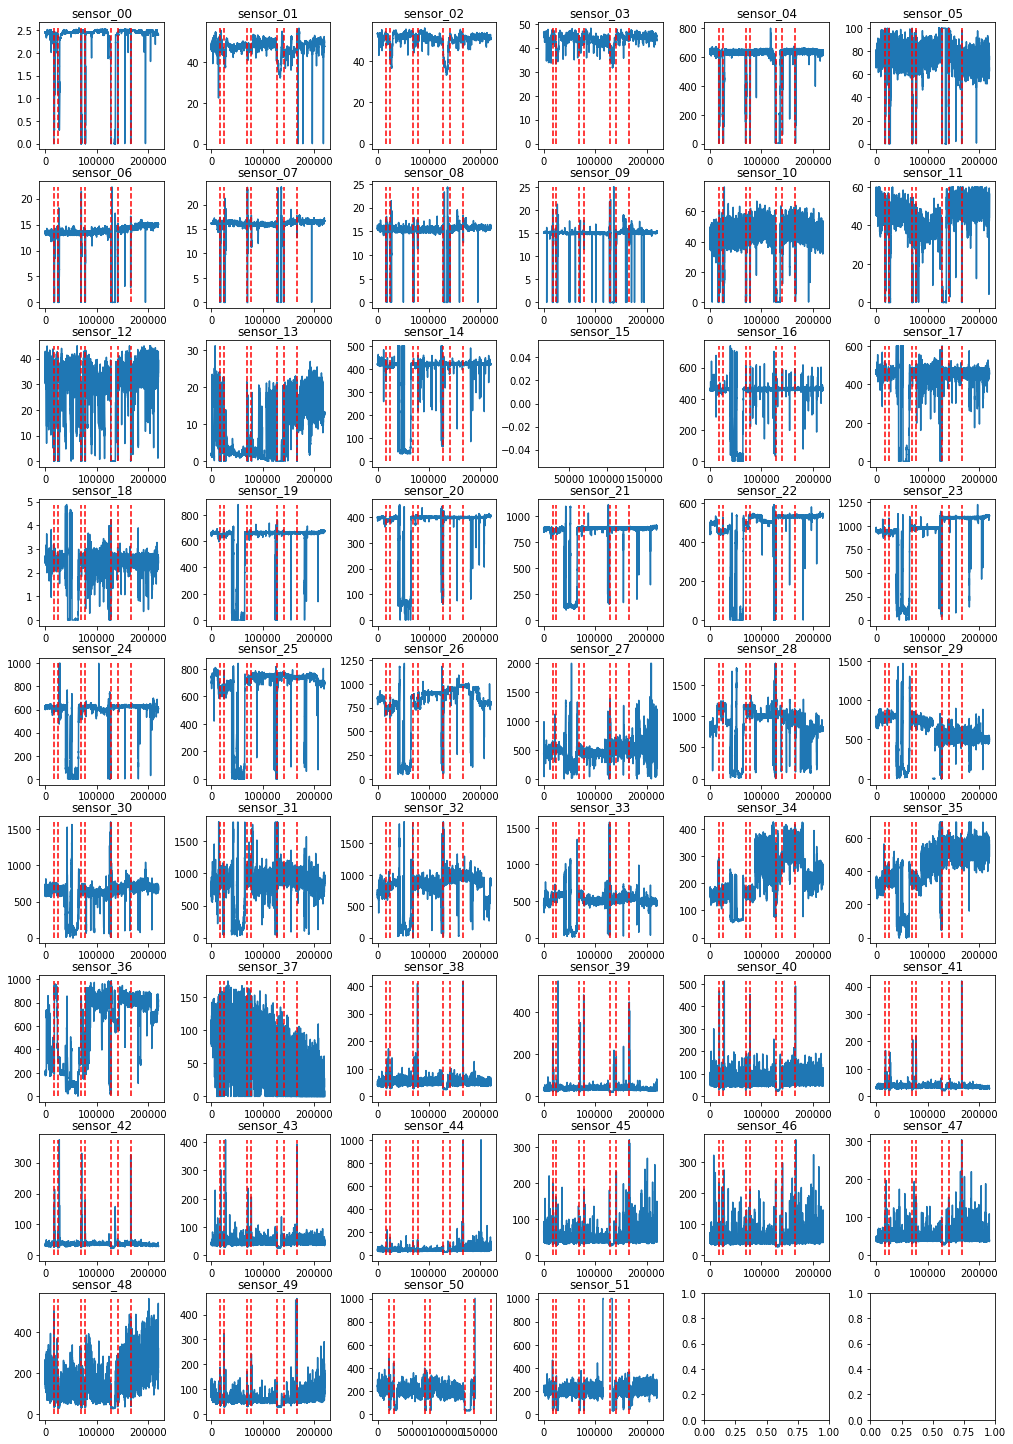

In [8]:
# General overview over all sensors throughout the measurement. 
# red dotted lines represent machine failure

ymin = 0
i = 0
fig, axs = plt.subplots(9, 6, figsize = (14,20))
fig.tight_layout()

for x0 in list(range(0, 9, 1)):
    #print('x0', x0)
    for y0 in list(range(0, 6, 1)):
        #print('x0 and y0', x0,  y0)
        if i < 10:
            sensor_number = 'sensor_0{}'.format(i)
            ymax = df[sensor_number].max()
        elif i > 51:
            break
        else:
            sensor_number = 'sensor_{}'.format(i)
        ymax = df[sensor_number].max()
        axs[x0, y0].plot(df[sensor_number])
        axs[x0, y0].set_title(sensor_number)
        axs[x0, y0].vlines(x = df[df['machine_status'] == 'BROKEN'].index, ymin = ymin, ymax = ymax, color='red', linestyle='--')
        i = i + 1

In [9]:
df.drop(['Unnamed: 0','sensor_00','sensor_15','sensor_50','sensor_51'], axis=1, inplace=True)

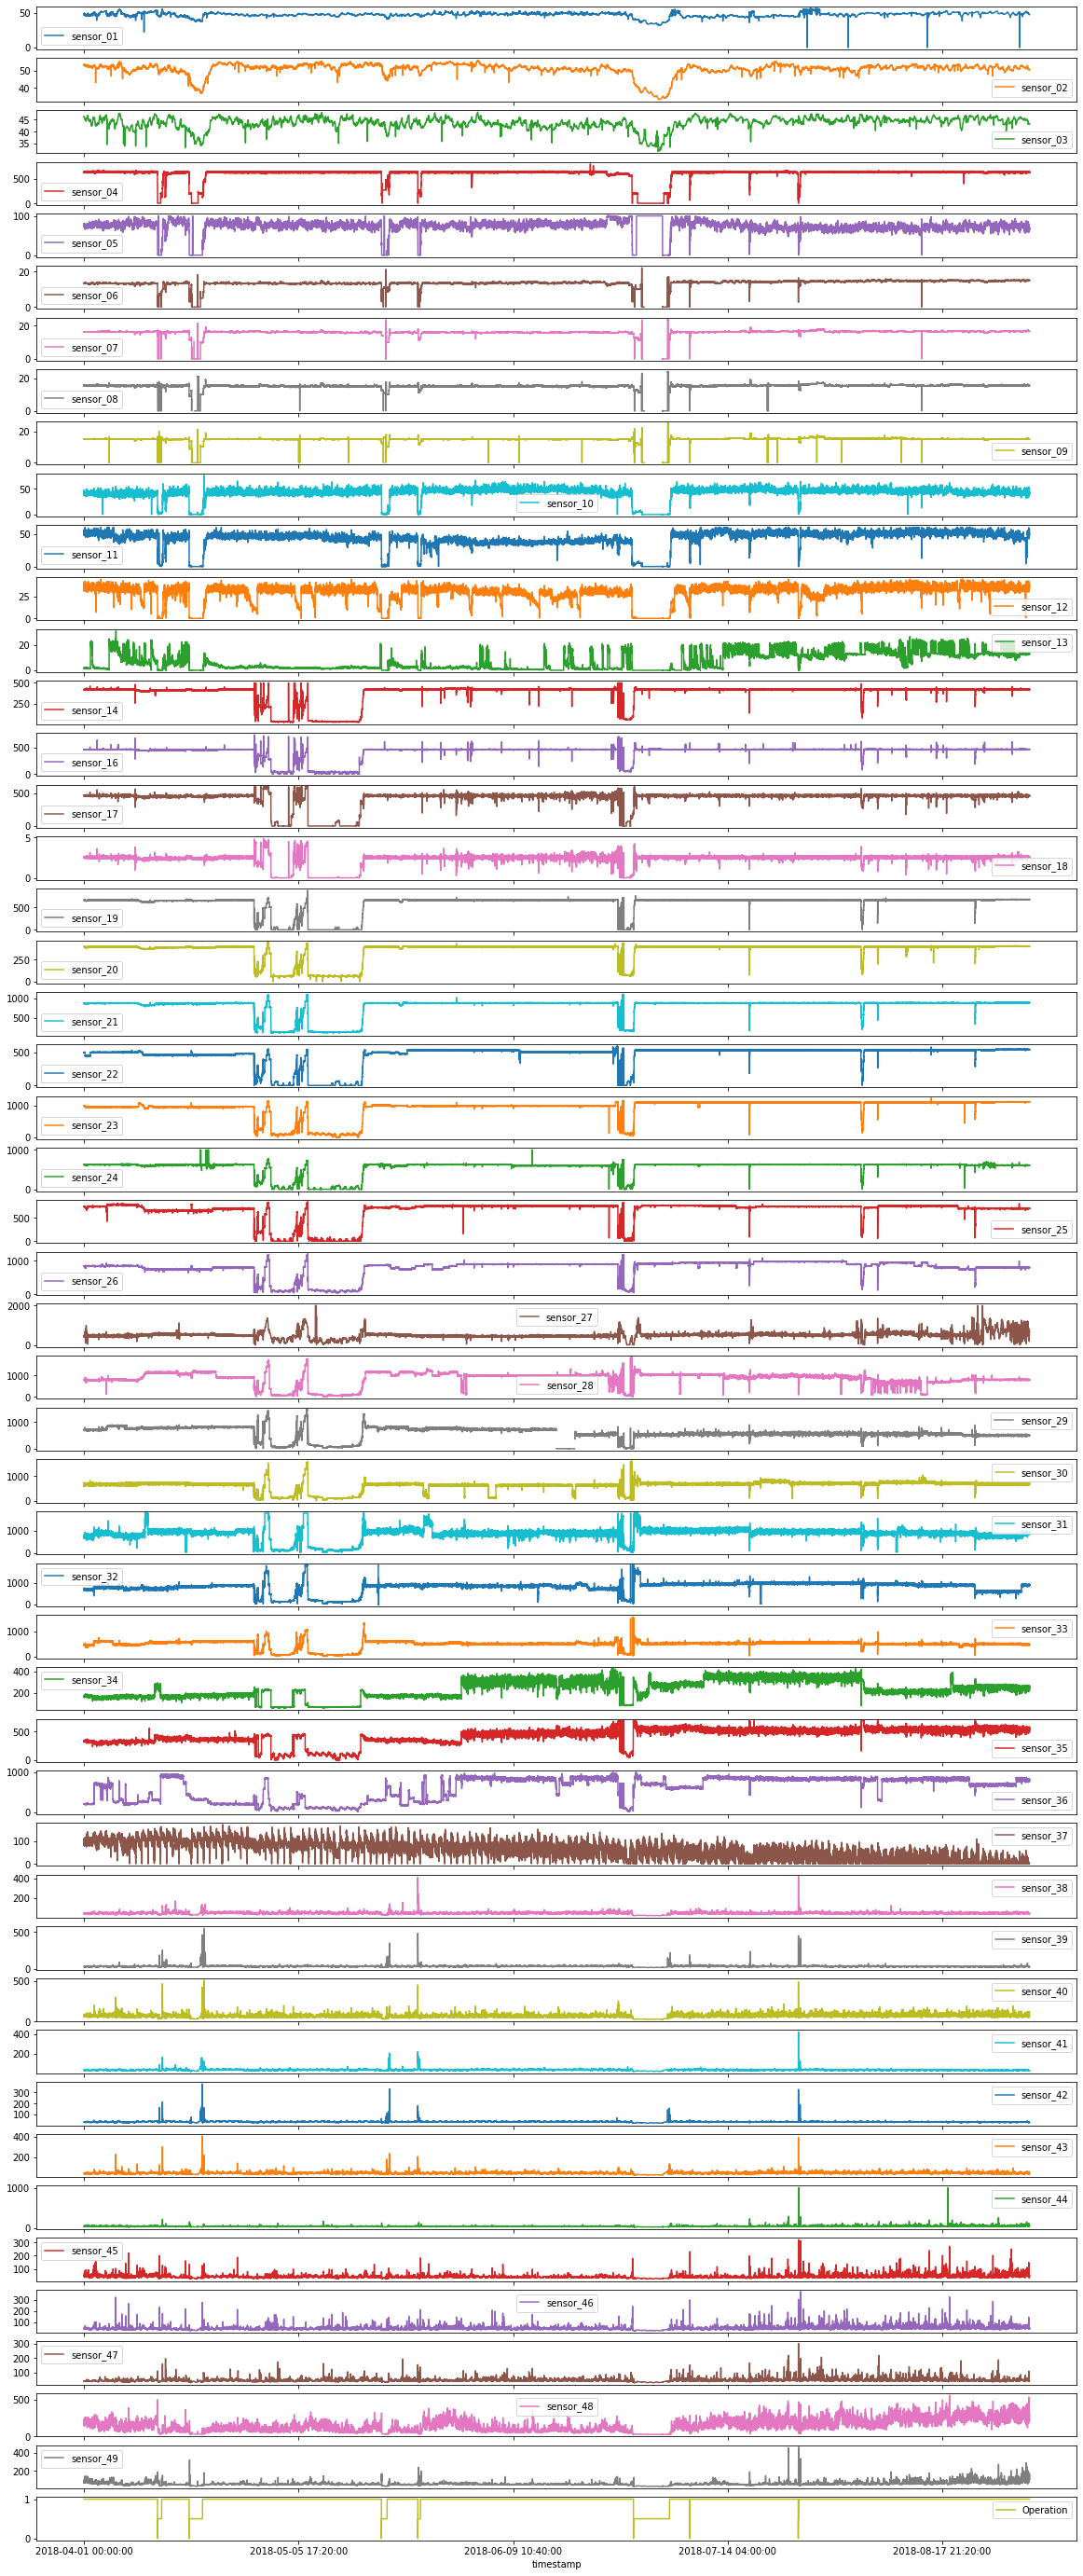

In [10]:
df.set_index('timestamp').plot(subplots =True, sharex = True, figsize = (20,50));

In [11]:
# Statistics of the machine. It is a highly imbalanced data set
df.machine_status.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

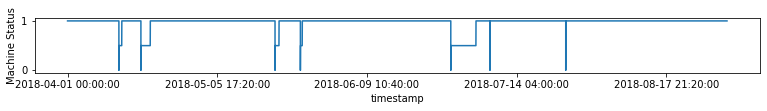

In [12]:
# Status of the machine. 1 = operational, 0.5 maintenance and 0 = broken
df.set_index('timestamp').Operation.plot(figsize=(13,1));
plt.ylabel('Machine Status');

# Machnine Learning without a Time Shift

In [13]:
# Columns I keep for the future analysis
to_convert = ['sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49']

In [14]:
df = df.backfill() # somehow fillna('backfill') produced columns with objects.')

In [15]:
df.isna().describe()

,timestamp,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status,Operation
count,220320,220320,220320,220320,220320,220320,220320,220320,220320,220320,...,220320,220320,220320,220320,220320,220320,220320,220320,220320,220320
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,220320,220320,220320,220320,220320,220320,220320,220320,220320,220320,...,220320,220320,220320,220320,220320,220320,220320,220320,220320,220320


In [16]:
df.set_index('timestamp', inplace=True)
df.index.freq = 'min' # df.index gets the frequency of the time series. It is needed for future steps.

In [17]:
# train/test split time series
train_df = df.loc[df.index < "2018-06-09 10:40:00"]
test_df = df.loc[df.index >= "2018-06-09 10:40:00"]
X_train = train_df.drop(['machine_status', 'Operation'], axis = 1)
y_train = train_df.Operation
X_test = test_df.drop(['machine_status', 'Operation'], axis = 1)
y_test = test_df.Operation

### Linear Regression

In [18]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

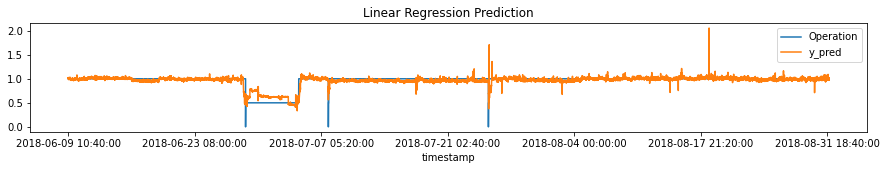

In [19]:
y_test_plot = y_test.copy()
y_test_plot = pd.DataFrame(y_test_plot)
y_test_plot['y_pred'] = y_pred.tolist()
y_test_plot.plot.line(figsize=(15,2));
plt.title('Linear Regression Prediction');

In [20]:
print('RMSE for Linear Regression: ', "%.3f" % mean_squared_error(y_pred, y_test)**(1/2))

RMSE for Linear Regression:  0.059


### Random Forrest

In [21]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

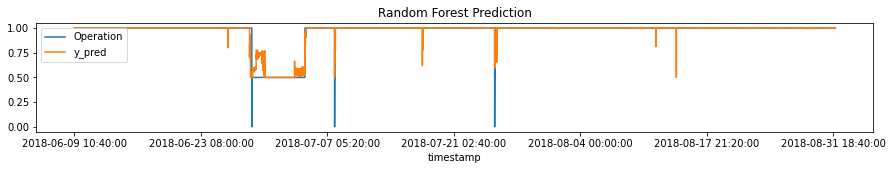

In [22]:
y_test_plot = pd.DataFrame(y_test_plot)
y_test_plot['y_pred'] = y_pred.tolist()
y_test_plot.plot.line(figsize=(15,2));
plt.title('Random Forest Prediction');

In [23]:
print('RMSE for Random Forest: ', "%.3f" % mean_squared_error(y_test, y_pred)**(1/2))

RMSE for Random Forest:  0.038


# Convert a Time Series to a Supervised Learning Problem: Sliding Window

Conclusively, random forest show a lower root mean square error (RMSE) than linear regression algorithm. It can better predict the underlying machine status. However, those example are not predicitions in advance. As both algorothms predict the machine fallout within a minute, which is to short
to take action or do a maintanace precedure. Therefore, a shift in the window function is necessary.

More information under the following link: https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

Shifting the  features 60 steps to be able to see the failure of the machine 60 minutes in advance.

You can play around with the time shift. Positive values push the time trace more into the future, while negative values pull the time back.
1440 minutes corresponds to a single day. The amount of time before the machine stops working.

In [24]:
for i in df.columns:
    if i == 'timestamp':
        continue
    else:
        for t in [180, 1440, 2880, 5760]: 
            df[f'{t}-{i}'] = df[i].shift(t)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


The next plot show the amount of Nans for each column

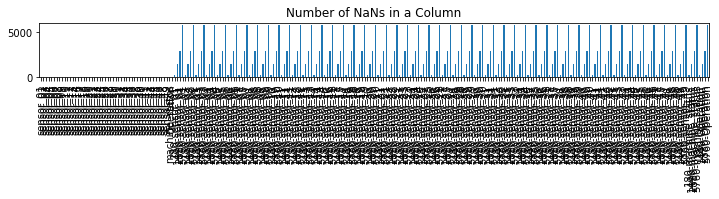

In [25]:
df.isna().sum().plot(kind='bar', figsize = (12, 1));
plt.title('Number of NaNs in a Column');

In [26]:
df = df.backfill() # somehow fillna('backfill') produced columns with objects.')
df.dropna(inplace = True) # those rows which contain NaNs due to the shift-method are now removed

As visible in the upcoming slide, Nans are not present any more

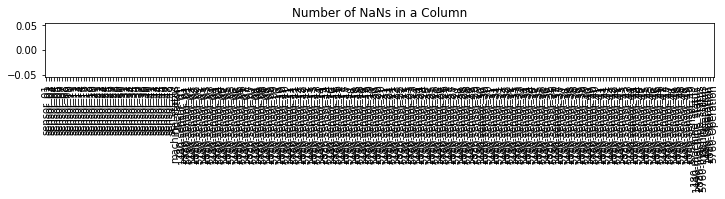

In [27]:
df.isna().sum().plot(kind='bar', figsize = (12, 1));
plt.title('Number of NaNs in a Column');

In [28]:
df.index.freq = 'min' # df.index gets the frequency of the time series. It is needed for future steps.

In [29]:
df_180 = pd.concat([df[df.columns[50::4]], df[df.columns[1:48:1]]], axis = 1)
df_1440 = pd.concat([df[df.columns[51::4]], df[df.columns[1:48:1]]], axis= 1)
df_2880 = pd.concat([df[df.columns[52::4]], df[df.columns[1:48:1]]], axis =1)
df_5760 = pd.concat([df[df.columns[53::4]], df[df.columns[1:48:1]]], axis = 1)

# 180 Minutes in Advance Prediction

In [30]:
number = 180
df_number = df_180
# train/test split time series. The dataset is split roughly 50:50 for training and test
train_df = df_number.loc[df.index < "2018-06-09 10:40:00"]
test_df = df_number.loc[df.index >= "2018-06-09 10:40:00"]

# X_train = train_df.drop(['machine_status', 'Operation'], axis = 1)
X_train = train_df.drop([f'{number}-machine_status', f'{number}-Operation'], axis = 1)
y_train = train_df[f'{number}-Operation']

# X_test = test_df.drop(['machine_status', 'Operation'], axis = 1)
X_test = test_df.drop([f'{number}-machine_status', f'{number}-Operation'], axis = 1)
X_test_plot = test_df.drop([f'{number}-machine_status'], axis = 1) # this is needed for the upcoming plot
y_test = test_df[f'{number}-Operation']

In [31]:
# Time when the machine status is broken
X_test_plot[X_test_plot['180-Operation'] == 0].index.tolist()

['2018-06-29 01:00:00', '2018-07-08 03:11:00', '2018-07-25 17:00:00']

In [32]:
# Linear Regression 
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

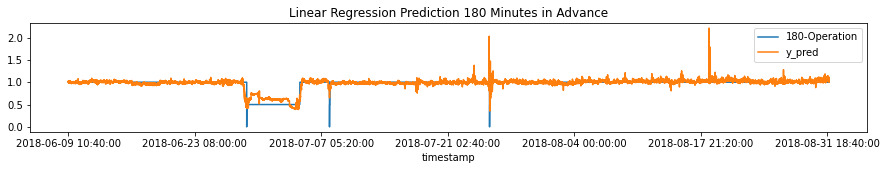

In [33]:
y_test_plot = y_test.copy()
y_test_plot = pd.DataFrame(y_test_plot)
y_test_plot['y_pred'] = y_pred.tolist()
y_test_plot.plot.line(figsize=(15,2));
plt.title(f'Linear Regression Prediction {number} Minutes in Advance');

In [34]:
print('RMSE for Linear Regression: ', "%.3f" % mean_squared_error(y_pred, y_test)**(1/2))

RMSE for Linear Regression:  0.056


In [35]:
# Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

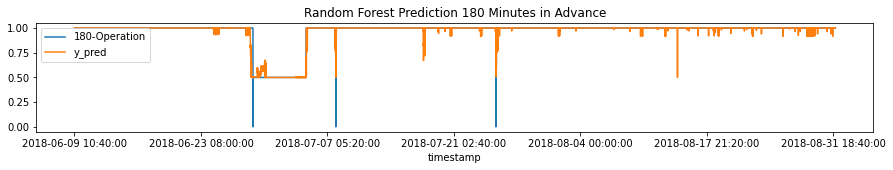

In [36]:
y_test_plot = y_test.copy()
y_test_plot = pd.DataFrame(y_test_plot)
y_test_plot['y_pred'] = y_pred.tolist()
y_test_plot.plot.line(figsize=(15,2));
plt.title(f'Random Forest Prediction {number} Minutes in Advance');

In [37]:
print('RMSE for Random Forest: ', "%.3f" % mean_squared_error(y_pred, y_test)**(1/2))

RMSE for Random Forest:  0.033


# 1440 Minutes in Advance Prediction

In [38]:
number = 1440
df_number = df_1440
# train/test split time series. The dataset is split roughly 50:50 for training and test
train_df = df_number.loc[df.index < "2018-06-09 10:40:00"]
test_df = df_number.loc[df.index >= "2018-06-09 10:40:00"]

# X_train = train_df.drop(['machine_status', 'Operation'], axis = 1)
X_train = train_df.drop([f'{number}-machine_status', f'{number}-Operation'], axis = 1)
y_train = train_df[f'{number}-Operation']

# X_test = test_df.drop(['machine_status', 'Operation'], axis = 1)
X_test = test_df.drop([f'{number}-machine_status', f'{number}-Operation'], axis = 1)
X_test_plot = test_df.drop([f'{number}-machine_status'], axis = 1) # this is needed for the upcoming plot
y_test = test_df[f'{number}-Operation']

In [39]:
# Linear Regression 
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

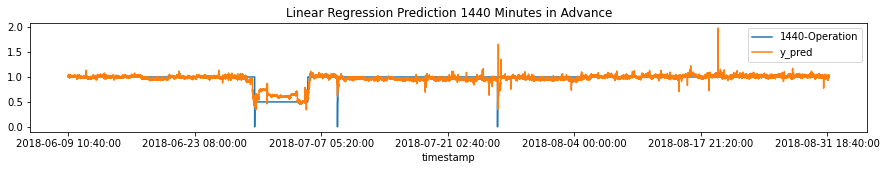

In [40]:
y_test_plot = y_test.copy()
y_test_plot = pd.DataFrame(y_test_plot)
y_test_plot['y_pred'] = y_pred.tolist()
y_test_plot.plot.line(figsize=(15,2));
plt.title(f'Linear Regression Prediction {number} Minutes in Advance');

In [41]:
print('RMSE for Linear Regression: ', "%.3f" % mean_squared_error(y_pred, y_test)**(1/2))

RMSE for Linear Regression:  0.059


In [42]:
# Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

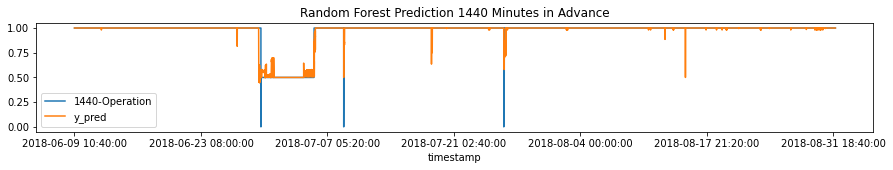

In [43]:
y_test_plot = y_test.copy()
y_test_plot = pd.DataFrame(y_test_plot)
y_test_plot['y_pred'] = y_pred.tolist()
y_test_plot.plot.line(figsize=(15,2));
plt.title(f'Random Forest Prediction {number} Minutes in Advance');

In [44]:
print('RMSE for Random Forest: ', "%.3f" % mean_squared_error(y_pred, y_test)**(1/2))

RMSE for Random Forest:  0.034


# 2880 Minutes in Advance Prediction

In [45]:
number = 2880
df_number = df_2880
# train/test split time series. The dataset is split roughly 50:50 for training and test
train_df = df_number.loc[df.index < "2018-06-09 10:40:00"]
test_df = df_number.loc[df.index >= "2018-06-09 10:40:00"]

# X_train = train_df.drop(['machine_status', 'Operation'], axis = 1)
X_train = train_df.drop([f'{number}-machine_status', f'{number}-Operation'], axis = 1)
y_train = train_df[f'{number}-Operation']

# X_test = test_df.drop(['machine_status', 'Operation'], axis = 1)
X_test = test_df.drop([f'{number}-machine_status', f'{number}-Operation'], axis = 1)
X_test_plot = test_df.drop([f'{number}-machine_status'], axis = 1) # this is needed for the upcoming plot
y_test = test_df[f'{number}-Operation']

In [46]:
# Linear Regression 
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

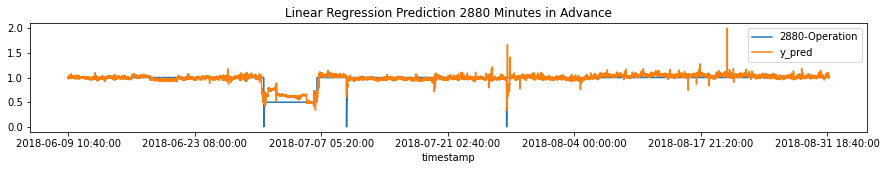

In [47]:
y_test_plot = y_test.copy()
y_test_plot = pd.DataFrame(y_test_plot)
y_test_plot['y_pred'] = y_pred.tolist()
y_test_plot.plot.line(figsize=(15,2));
plt.title(f'Linear Regression Prediction {number} Minutes in Advance');

In [48]:
print('RMSE for Linear Regression: ', "%.3f" % mean_squared_error(y_pred, y_test)**(1/2))

RMSE for Linear Regression:  0.060


In [49]:
# Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

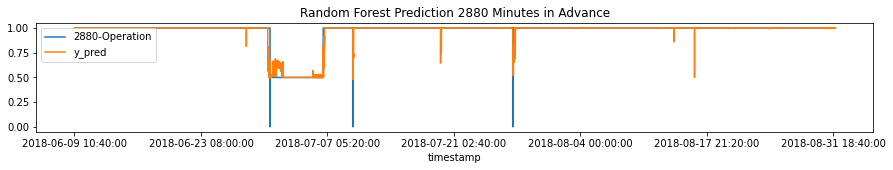

In [50]:
y_test_plot = y_test.copy()
y_test_plot = pd.DataFrame(y_test_plot)
y_test_plot['y_pred'] = y_pred.tolist()
y_test_plot.plot.line(figsize=(15,2));
plt.title(f'Random Forest Prediction {number} Minutes in Advance');

In [51]:
print('RMSE for Random Forest: ', "%.3f" % mean_squared_error(y_pred, y_test)**(1/2))

RMSE for Random Forest:  0.034


# 5760 Minutes in Advance Prediction

In [52]:
number = 5760
df_number = df_5760
# train/test split time series. The dataset is split roughly 50:50 for training and test
train_df = df_number.loc[df.index < "2018-06-09 10:40:00"]
test_df = df_number.loc[df.index >= "2018-06-09 10:40:00"]

# X_train = train_df.drop(['machine_status', 'Operation'], axis = 1)
X_train = train_df.drop([f'{number}-machine_status', f'{number}-Operation'], axis = 1)
y_train = train_df[f'{number}-Operation']

# X_test = test_df.drop(['machine_status', 'Operation'], axis = 1)
X_test = test_df.drop([f'{number}-machine_status', f'{number}-Operation'], axis = 1)
X_test_plot = test_df.drop([f'{number}-machine_status'], axis = 1) # this is needed for the upcoming plot
y_test = test_df[f'{number}-Operation']

In [53]:
# Linear Regression 
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

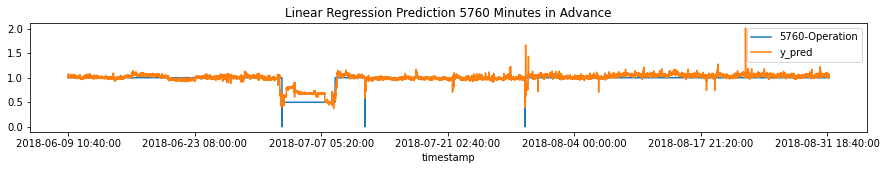

In [54]:
y_test_plot = y_test.copy()
y_test_plot = pd.DataFrame(y_test_plot)
y_test_plot['y_pred'] = y_pred.tolist()
y_test_plot.plot.line(figsize=(15,2));
plt.title(f'Linear Regression Prediction {number} Minutes in Advance');

In [55]:
# Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

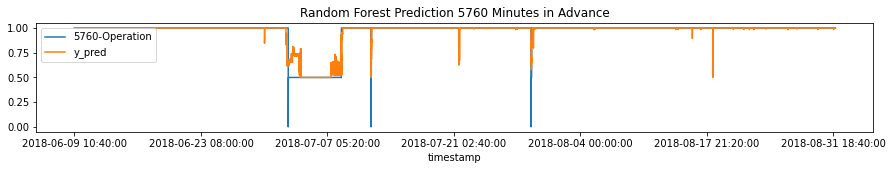

In [56]:
y_test_plot = y_test.copy()
y_test_plot = pd.DataFrame(y_test_plot)
y_test_plot['y_pred'] = y_pred.tolist()
y_test_plot.plot.line(figsize=(15,2));
plt.title(f'Random Forest Prediction {number} Minutes in Advance');

In [57]:
print('RMSE for Random Forest: ', "%.3f" % mean_squared_error(y_pred, y_test)**(1/2))

RMSE for Random Forest:  0.036


# Conclusion

The notebook showed that a time series analysis with a supervides ML algorithm such as random forest is possible. Also this notebook investigated some time interval to predict machine failure in advance. As the result suggest pump failure can be predicted upto 4 days in advance. However, whether this result are solid proof remains uncertain. Both for 180 minutes and 4 days before machine failure the ML algorithm performed equally well, which is surprising. 